# <b>DS3000 Group Project</b>

# <b>Chef.AI</b> - Lukas Bozinov & Arjun Atwal - Group 31

## Section 0 - Preliminary Code

### Section 0.1: Import all necessary libraries

In [1]:
import numpy as np #etc etc etc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
import csv, ast, math, os
from groq import Groq
from dotenv import load_dotenv

## Section 1 - Organization of Dataset

### Section 1.1: Parse the dataset
Formatting data into a format that is easily passed to math functions.

In [4]:
# written by lukas (i am the goat)

load_dotenv()
a=os.getenv("OPENAI_API_KEY")
print(a)

class Food:
    def __init__(self, food_name, food_group, colour_day, mass_day, temp_day):
        self.food_name = food_name
        self.food_group = food_group
        self.colour_day = colour_day
        self.mass_day = mass_day
        self.temp_day = temp_day

    def __str__(self):
        return (
            f"Food Name: {self.food_name}\n"
        )

foodList_train = []

with open('ourData.csv', "r") as commentedFile: 
    reader = csv.reader(commentedFile)
    next(reader)  # skip line of headers

    for row in reader:
        food_name = row[0].strip()
        food_group = row[1].strip()
        colour_day_raw = row[2].strip()
        mass_day_raw = row[3].strip()
        temp_day_raw = row[4].strip()

        colour_day_list = ast.literal_eval(colour_day_raw)
        mass_day_list = ast.literal_eval(mass_day_raw)
        temp_day_list = ast.literal_eval(temp_day_raw)

        # Use lists instead of dictionaries because duplicate values erases entries that we need
        colour_day = colour_day_list
        mass_day = mass_day_list
        temp_day = temp_day_list

        food = Food(food_name, food_group, colour_day, mass_day, temp_day)

        foodList_train.append(food)

# get total number of days for later processing
numDays_train = len(foodList_train[0].colour_day)

#TEST

foodList_test = []

with open('ourDataTest.csv', "r") as commentedFile: 
    reader = csv.reader(commentedFile)
    next(reader)  # skip line of headers

    for row in reader:
        food_name = row[0].strip()
        food_group = row[1].strip()
        colour_day_raw = row[2].strip()
        mass_day_raw = row[3].strip()
        temp_day_raw = row[4].strip()

        colour_day_list = ast.literal_eval(colour_day_raw)
        mass_day_list = ast.literal_eval(mass_day_raw)
        temp_day_list = ast.literal_eval(temp_day_raw)

        # Use lists instead of dictionaries because duplicate values erases entries that we need
        colour_day = colour_day_list
        mass_day = mass_day_list
        temp_day = temp_day_list

        food = Food(food_name, food_group, colour_day, mass_day, temp_day)

        foodList_test.append(food)

# get total number of days for later processing
numDays_test = len(foodList_test[0].colour_day)



None


### Section 1.2: Data Pre-Processing (training/test set initialization, freshness index function definition)

In [5]:
# import deez

def freshness_index(time, mass_initial, mass_curr, temp_curr, temp_optimal, color_curr, color_optimal, weight_mass = 0.5, weight_temp = 0.3, weight_color = 0.2, alpha = 0.3, sigma = 5, lambda_ = 0.05):

    # Mass Factor - not certain about this
    mass_factor = (math.exp(-alpha * time * (mass_curr / mass_initial))) * weight_mass
    # print(mass_factor)

    # Temperature Factor
    temp_factor = math.exp(-((temp_curr - temp_optimal) ** 2) / (2 * sigma ** 2)) * weight_temp
    # print(temp_factor)

    # Color Factor - asm color_curr, color_optimal are in range RGB(0-255, 0-255, 0-255)
    color_diff = math.sqrt((color_curr[0] - color_optimal[0]) ** 2 + (color_curr[1] - color_optimal[1]) ** 2 + (color_curr[2] - color_optimal[2]) ** 2)
    color_factor = math.exp(-lambda_ * color_diff) * weight_color
    # print(color_factor)

    # Freshness Index
    freshness_index = mass_factor + temp_factor + color_factor
    return min(1, freshness_index) # with the weights summing to 1, the maximum value of the freshness index is 1

def train_freshness_index(food_name):

    # find the food object
    food = None
    for i in range(len(foodList_train)):
        if foodList_train[i].food_name == food_name:
            food = foodList_train[i]
            break

    if food == None:
        print('Food not found')
        exit()

    # find the index of the food object
    food_index = foodList_train.index(food)

    # initialize optimal values for the freshness_index function
    color_optimal = (foodList_train[food_index].colour_day[0][0])
    temp_optimal = foodList_train[food_index].temp_day[0][0]
    mass_initial = foodList_train[food_index].mass_day[0][0]

    days = []
    for i in range(numDays_train):
        days.append(i)

        #freshness_values = np.array([1.0, 0.710923868536591, 0.63709970475181, 0.511606076772564, 0.44434784966860497, 0.40576335646495826, 0.381205757697219])

    days = np.array(days)

    freshness_values_train = []

    for i in range(numDays_train):
        color_curr = (foodList_train[food_index].colour_day[i][0])
        temp_curr = foodList_train[food_index].temp_day[i][0]
        mass_curr = foodList_train[food_index].mass_day[i][0]
        time = i

        print('Time =', time)
        freshnessindex_train = freshness_index(time, mass_initial, mass_curr, temp_curr, temp_optimal, color_curr, color_optimal)
        print(freshnessindex_train)
        freshness_values_train.append(freshnessindex_train)

    freshness_values_train = np.array(freshness_values_train)

    print(days)
    print(freshness_values_train)
    return days, freshness_values_train

def test_freshness_index(food_name):

    #TEST - dont need to ask for food name again

    # find the food object
    food = None
    for i in range(len(foodList_test)):
        if foodList_test[i].food_name == food_name:
            food = foodList_test[i]
            break

    if food == None:
        print('Food not found')
        exit()

    # find the index of the food object
    food_index = foodList_test.index(food)

    # initialize optimal values for the freshness_index function
    color_optimal = (foodList_test[food_index].colour_day[0][0])
    temp_optimal = foodList_test[food_index].temp_day[0][0]
    mass_initial = foodList_test[food_index].mass_day[0][0]

    days_test = []
    for i in range(numDays_test):
        days_test.append(i)

        #freshness_values = np.array([1.0, 0.710923868536591, 0.63709970475181, 0.511606076772564, 0.44434784966860497, 0.40576335646495826, 0.381205757697219])

    days_test = np.array(days_test)

    freshness_values_test = []

    for i in range(numDays_test):
        color_curr = (foodList_test[food_index].colour_day[i][0])
        temp_curr = foodList_test[food_index].temp_day[i][0]
        mass_curr = foodList_test[food_index].mass_day[i][0]
        time = i

        print('Time =', time)
        freshnessindex_test = freshness_index(time, mass_initial, mass_curr, temp_curr, temp_optimal, color_curr, color_optimal)
        print(freshnessindex_test)
        freshness_values_test.append(freshnessindex_test)

    freshness_values_test = np.array(freshness_values_test)

    print(days_test)
    print(freshness_values_test)
    return days_test, freshness_values_test



## Section 2 - Mathematical Function Initialization

### Section 2.1: Sigmoid Function Declaration

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

def freshness_sigmoid_model(t, L, k, t_0):
    return L / (1 + np.exp(-k * (t - t_0)))



def sigmoid_model_regression(days, freshness_values_train, days_test, freshness_values_test):

    # Assuming days, days_test, freshness_values_train, and freshness_values_test are already defined. 
    days_train = days
    freshness_train = freshness_values_train
    days_test = days_test
    freshness_test = freshness_values_test

    # Provide initial parameter guesses and increase maxfev
    initial_guesses = [1, 1, 12]

    params, covariance = curve_fit(
        freshness_sigmoid_model,
        days_train,
        freshness_train,
        p0=initial_guesses,
        maxfev=20000
    )

    L, k, t_0 = params

    predicted_train = freshness_sigmoid_model(days_train, L, k, t_0)
    predicted_test = freshness_sigmoid_model(days_test, L, k, t_0)

    mse_train = mean_squared_error(freshness_train, predicted_train)
    mse_test = mean_squared_error(freshness_test, predicted_test)

    print(f"Mean Squared Error on Training Data: {mse_train}")
    print(f"Mean Squared Error on Test Data: {mse_test}")

    r2_train = r2_score(freshness_train, predicted_train)
    r2_test = r2_score(freshness_test, predicted_test)

    print(f"R^2 on Training Data: {r2_train}")
    print(f"R^2 on Test Data: {r2_test}")

    days_extended = np.linspace(0, 24, 100)
    predicted_freshness = freshness_sigmoid_model(days_extended, L, k, t_0)

    # Find the day when the freshness index equals 0.8, 0.6, and 0.4
    target_values = [0.8, 0.6, 0.4]
    target_days = {}

    for target in target_values:
        closest_day = None
        closest_diff = float('inf')
        for i in range(len(predicted_freshness)):
            diff = abs(predicted_freshness[i] - target)
            if diff < closest_diff:
                closest_diff = diff
                closest_day = days_extended[i]
        target_days[target] = closest_day

    for target, day in target_days.items():
        print(f"Day when freshness index is closest to {target}: {day}")

    plt.scatter(days, freshness_values_train, color='blue', label='Observed Data Points')
    plt.plot(days_extended, predicted_freshness, color='red', label='Nonlinear Sigmoid Decay Curve')
    plt.xlabel('Days')
    plt.ylabel('Freshness Index')
    plt.title('Nonlinear Freshness Index Decay with Expected Spoilage at Day 7')
    plt.legend()
    plt.show()

    return target_days

# sigmoid_model_regression()

### Section 2.2: Non-linear regression line to predict Freshness Index of each selected food (with graph output)

Time = 0
1
Time = 1
0.710923868536591
Time = 2
0.63709970475181
Time = 3
0.511606076772564
Time = 4
0.44434784966860497
Time = 5
0.40576335646495826
Time = 6
0.381205757697219
[0 1 2 3 4 5 6]
[1.         0.71092387 0.6370997  0.51160608 0.44434785 0.40576336
 0.38120576]
Time = 0
1
Time = 1
0.7131630360573626
Time = 2
0.6425531404188921
Time = 3
0.4948446994286173
Time = 4
0.46135035350384773
Time = 5
0.38234044107776954
Time = 6
0.380944703280409
[0 1 2 3 4 5 6]
[1.         0.71316304 0.64255314 0.4948447  0.46135035 0.38234044
 0.3809447 ]
Mean Squared Error on Training Data: 0.0021799152575388524
Mean Squared Error on Test Data: 0.0022237824629878443
R^2 on Training Data: 0.9473125743640247
R^2 on Test Data: 0.947769419088828
Day when freshness index is closest to 0.8: 0.9696969696969697
Day when freshness index is closest to 0.6: 2.4242424242424243
Day when freshness index is closest to 0.4: 4.848484848484849


/var/folders/yn/mrj5wlcn5413qz7236tzylpm0000gn/T/ipykernel_83829/1039339099.py:7: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (t - t_0)))


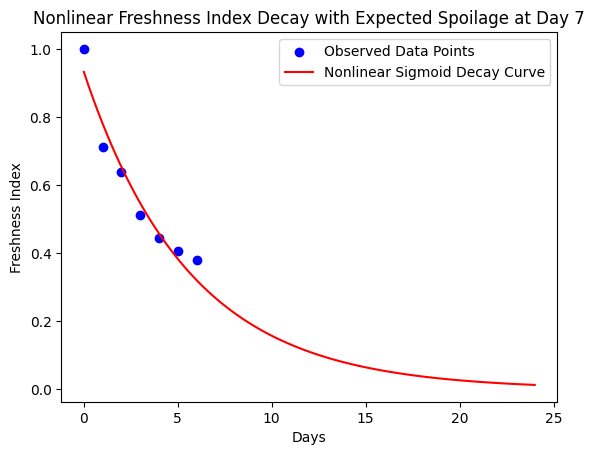

[('Apple', {0.8: np.float64(0.9696969696969697), 0.6: np.float64(2.4242424242424243), 0.4: np.float64(4.848484848484849)})]


In [42]:
# take target_days which contains the days when the freshness index is closest to 0.8, 0.6, and 0.4
# these are our categories, anything before 0.8 is good to eat, anything between 0.8 and 0.6 is okay to eat, and anything after 0.6 is bad to eat
# loop the above for all foods (or however many we wish to analyze) and store the results in a dictionary or something
# then, simply go week by week
# optimize meal planning based on this information

inputted_foods = []
freshness_values_per_food = []

try:
    n = int(input('How many foods would you like to analyze? For best results, enter a number above 3: '))
except ValueError:
    print("Invalid input. Please enter a valid number.")
    n = int(input('How many foods would you like to analyze? '))

for item in range(n):
    # which food are we looking at
    for i in range(len(foodList_train)):  # print all options
        food_options = [foodList_train[i].food_name for i in range(len(foodList_train))]
    food_name = input('\nEnter the name of the food you would like to analyze:\nOptions are ' + ', '.join(food_options) + '\n')

    inputted_foods.append(food_name)

    train_values = train_freshness_index(food_name)
    test_values = test_freshness_index(food_name)
    freshness_values = sigmoid_model_regression(train_values[0], train_values[1], test_values[0], test_values[1])
    freshness_values_per_food.append((food_name, freshness_values))

print(freshness_values_per_food)


    
    





## Section 3 - Output the Recipe (Groq)

### Section 3.1 - Which foods are the freshest?

In [41]:
num_recs = (len(freshness_values_per_food) / 3)
# print(num_recs)
num_recs_08 = math.ceil(num_recs)
# print(num_recs_08)
num_recs_06 = math.floor(num_recs)
# print(num_recs_06)
num_recs_04 = math.floor(num_recs)
# print(num_recs_04)

# for 0.8
recs_08 = []
for i in range(num_recs_08):
    min_08 = float('inf')
    for food in freshness_values_per_food:
        if food[1][0.8] < min_08:
            min_08 = food[1][0.8]
            min_food = food
    recs_08.append(min_food[0])
    freshness_values_per_food.remove(min_food)
print("You should eat " + ", ".join(recs_08) + " first\n")

# for 0.6
recs_06 = []
for i in range(num_recs_06):
    min_06 = float('inf')
    for food in freshness_values_per_food:
        if food[1][0.6] < min_06:
            min_06 = food[1][0.6]
            min_food = food
    recs_06.append(min_food[0])
    freshness_values_per_food.remove(min_food)
print("Then you should eat " + ", ".join(recs_06) + " next\n")

num_recs = int(num_recs)
# for 0.4
recs_04 = []
for i in range(num_recs_04):
    min_04 = float('inf')
    for food in freshness_values_per_food:
        if food[1][0.4] < min_04:
            min_04 = food[1][0.4]
            min_food = food
    recs_04.append(min_food[0])
    freshness_values_per_food.remove(min_food)
print("And save " + ", ".join(recs_04) + " for last\n")

prompt = ""
for i in inputted_foods:
    prompt += (i + ", ")

print(prompt)

client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

client = Groq()


chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "You are a chef."
        },
        {
            "role": "user",
            "content": "Give me a recipe that I can make that exclusively uses these ingredients: Do not use any other items except for common household items like seasoning, oil, etc." + prompt,
        }
    ],

    model="llama3-8b-8192"
)

print(chat_completion.choices[0].message.content)



    



You should eat Apple first

Then you should eat  next

And save  for last

Apple, 


GroqError: The api_key client option must be set either by passing api_key to the client or by setting the GROQ_API_KEY environment variable

### Section 3.2: Prompt output

In [ ]:
prompt = ""
for i in inputted_foods:
    prompt += (i + ", ")

print(prompt)

client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

client = Groq()


chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "You are a chef."
        },
        {
            "role": "user",
            "content": "Give me a recipe that I can make that exclusively uses these ingredients: Do not use any other items except for common household items like seasoning, oil, etc." + prompt,
        }
    ],

    model="llama3-8b-8192"
)

print(chat_completion.choices[0].message.content)

Apple, Celery, Naan Bread, Iceberg Lettuce, 
Creative challenge! Here's a unique recipe that only uses the given ingredients, plus some common household items like seasoning and oil:

**Autumn Harvest Naan Wrap**

Ingredients:

* 1 Naan Bread
* 1 Apple, diced
* 2 stalks Celery, diced
* 2 Leaves Iceberg Lettuce
* Salt and Pepper to taste
* Cooking Oil for brushing

Instructions:

1. Preheat your oven to 350°F (180°C).
2. Brush one side of the Naan Bread with a small amount of cooking oil.
3. Place the Naan Bread, oiled side down, on a baking sheet.
4. Top the Naan Bread with a layer of diced Apple. You can use as much or as little as you like, depending on your taste.
5. Add a layer of diced Celery on top of the Apple. Again, use as much or as little as you like.
6. Place two leaves of Iceberg Lettuce on top of the Celery.
7. Season with salt and pepper to taste.
8. Flip the Naan Bread over, so the un-oiled side is facing up.
9. Bake in the preheated oven for 10-12 minutes, or until the